In [8]:
# Imports:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import dxchange
import nibabel as nib
import tifffile
from skimage.filters import threshold_otsu
from skimage.morphology import closing, isotropic_closing, disk, ball, cube

# change directory to the project directory
os.chdir('/dtu/3d-imaging-center/courses/02509/groups/members/s194333/HPC3D_project')

In [2]:
# load the data of the stone for which to make a mask
folder_path = '/dtu/3d-imaging-center/courses/02509/groups/group01/island_gammel'
file_name = 'lavasten_Island_gammel_LFOV-80kV-LE5-4s-45.3micro_recon.txm'
absolute_path = os.path.join(folder_path, file_name)
all_data = dxchange.reader.read_txm(absolute_path)

In [3]:
# get the data and the inspect the metadata
data = all_data[0]
pixel_size = all_data[1]['pixel_size']
print(f'Pixel size: {pixel_size}')
img_shape = data.shape
print(f'Image shape: {img_shape}')
img_shape_array = np.array(img_shape)
total_size = img_shape_array * pixel_size
total_size__mm = total_size/1000
print(f'Total size in mm: {total_size}')
pixel_size_mm = pixel_size/1000
print(f'Pixel size in mm: {pixel_size_mm}')
pixels_per_mm = 1/pixel_size_mm
print(f'Pixels per mm: {pixels_per_mm}')

Pixel size: 45.34814453125
Image shape: (1017, 1024, 1004)
Total size in mm: [46119.06298828 46436.5        45529.53710938]
Pixel size in mm: 0.04534814453125
Pixels per mm: 22.051618877391707


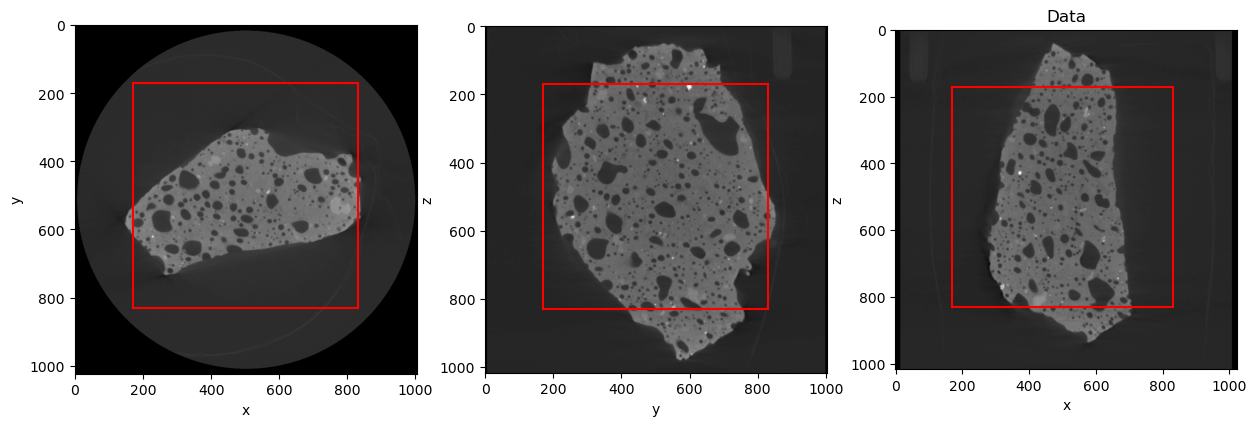

In [4]:
# crop the data to a big region of interest on which to use otsu thresholding
crop_size = int(30*pixels_per_mm)

start_x = 170
end_x = start_x + crop_size
start_y = 170
end_y = start_y + crop_size
start_z = 170
end_z = start_z + crop_size

# select the slice to visualize
slice = crop_size//2  #crop_size # 0
slice_x = start_x + slice
slice_y = start_y + slice
slice_z = start_z + slice

# visualize the data and the region of interest
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(data[slice_z, :, :], cmap='gray')
ax[0].plot([start_x, end_x], [start_y, start_y], 'r')
ax[0].plot([start_x, end_x], [end_y, end_y], 'r')
ax[0].plot([start_x, start_x], [start_y, end_y], 'r')
ax[0].plot([end_x, end_x], [start_y, end_y], 'r')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].imshow(data[:,slice_x, :], cmap='gray')
ax[1].plot([start_y, end_y], [start_z, start_z], 'r')
ax[1].plot([start_y, end_y], [end_z, end_z], 'r')
ax[1].plot([start_y, start_y], [start_z, end_z], 'r')
ax[1].plot([end_y, end_y], [start_z, end_z], 'r')
ax[1].set_xlabel('y')
ax[1].set_ylabel('z')
ax[2].imshow(data[:, :, slice_y], cmap='gray')
ax[2].plot([start_x, end_x], [start_z, start_z], 'r')
ax[2].plot([start_x, end_x], [end_z, end_z], 'r')
ax[2].plot([start_x, start_x], [start_z, end_z], 'r')
ax[2].plot([end_x, end_x], [start_z, end_z], 'r')
ax[2].set_xlabel('x')
ax[2].set_ylabel('z')
plt.title('Data')
plt.show()

In [5]:
# crop the data to the region of interest and apply otsu thresholding
data_crop = data[start_z:end_z, start_x:end_x, start_y:end_y]
global_threshold_otsu = threshold_otsu(data_crop)
print(f'Global threshold otsu: {global_threshold_otsu}')

Global threshold otsu: 12172


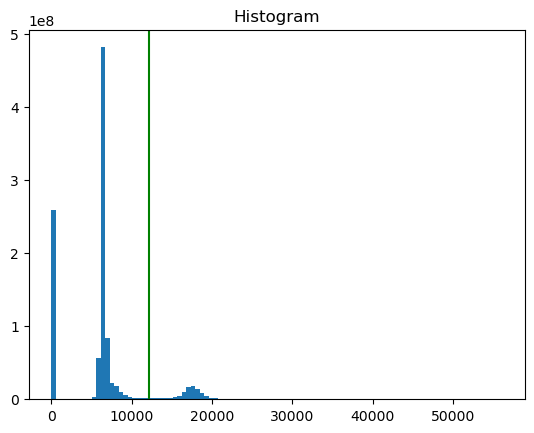

In [6]:
# visualize the cropped data and the threshold
plt.hist(data.flatten(), bins=100)
plt.axvline(global_threshold_otsu, color='g')
plt.title('Histogram')
plt.show()


In [9]:
# binarize the data
bin_data = data > global_threshold_otsu
bin_data = bin_data.astype(np.uint8)

# Use morphological closing to close the bubbles on the edges of the stone
# choose a suitable footprint
footprint = cube(51)

closed_data = closing(bin_data, footprint)

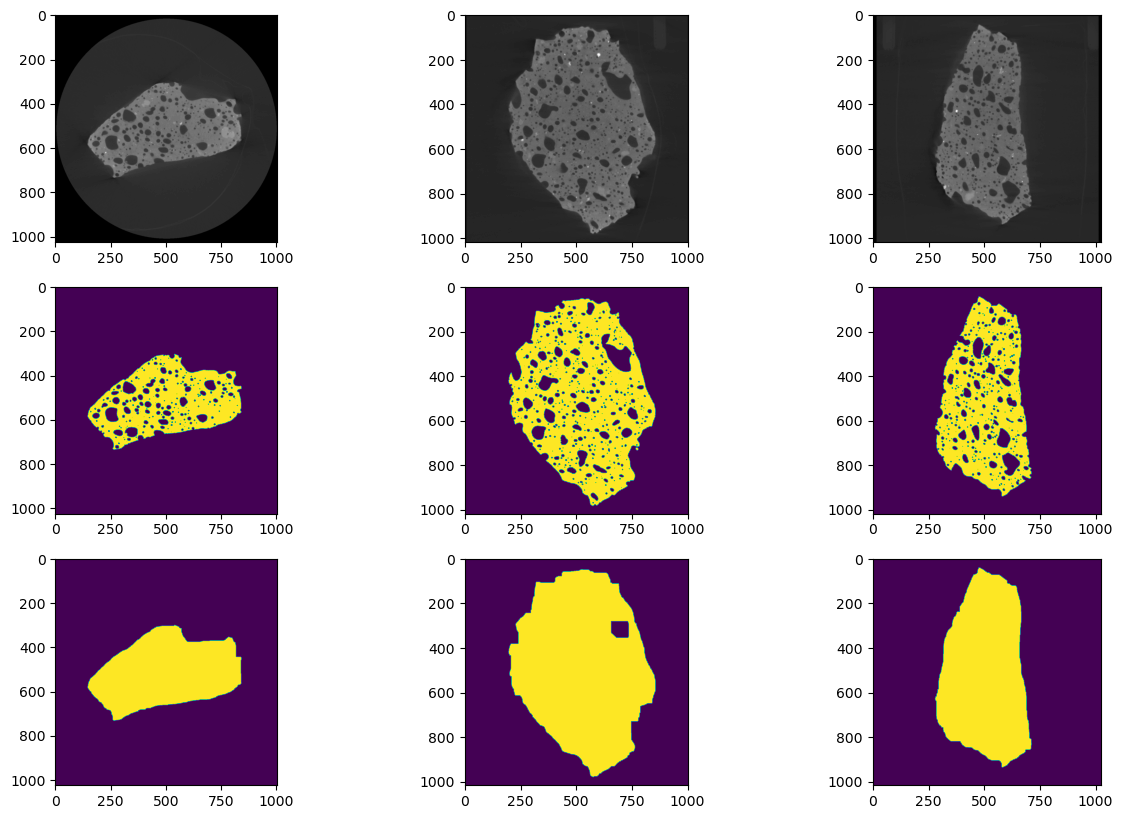

In [10]:
# visualize the data, the binarized data and the closed data
slice = 500
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
ax[0,0].imshow(data[slice, :, :], cmap='gray')
ax[0,1].imshow(data[:,slice, :], cmap='gray')
ax[0,2].imshow(data[:, :, slice], cmap='gray')
ax[1,0].imshow(bin_data[slice, :, :])
ax[1,1].imshow(bin_data[:,slice, :])
ax[1,2].imshow(bin_data[:, :, slice])
ax[2,0].imshow(closed_data[slice, :, :])
ax[2,1].imshow(closed_data[:,slice, :])
ax[2,2].imshow(closed_data[:, :, slice])

plt.show()

In [11]:
# save the bin data
file_name = 'bin_data.tiff'
absolute_path = os.path.join(folder_path, file_name)
dxchange.write_tiff(bin_data, absolute_path, dtype='uint8', overwrite=True)

# save the segmented data
file_name = 'closed_data.tiff'
absolute_path = os.path.join(folder_path, file_name)
dxchange.write_tiff(closed_data, absolute_path, dtype='uint8', overwrite=True)

# do active contour segmentation in ITK-SNAP to get the final mask.